# **Active Learning**
*By Eyal Betzalel*

*In this notebook I will use active learning techniques on MNIST dataset in a classification task.*
*I will present the concepts behind active learning, and explore how different hyper parameters and algorithms effect on the learning preformances.*

Active learning is a tool that aims to solve the problem of labeling large dataset manually for machine learning algorithms. 

The concept behind active learning is that if a learning algorithm could pronounce his necessities, and query challenging cases - it can perform better than traditional methods with substantially less data for training.



####**Active Learning Algorithm Explanation:**

1. Divide the data to a ‘pool’ and a test-set. Select ‘k’ samples from the pool for the initial train-set and label them, the remaining data will be the validation-set.
2. Normalize all the sets and train the model using the train-set, with balanced weights.
3. Use the trained model with the validation-set, get probabilities per sample.
4. Use query selection methods in order to rate the uncertinty in each sample clasiification, then sort the database by this value and choose 'k' samples with the largest uncertinty.
5. Move these ‘k’ samples from the validation set to the train-set and query their labels, then train the model again with new training set.

Stop according to the stop criteria, otherwise go to 2.

![alt text](https://drive.google.com/uc?id=1aEEpeEyKjl04h7320-kkJnhC9H3bfAWJ)


Import Project Dependencies: 

In [0]:
import torch
import torchvision as tv
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from sklearn.cluster import KMeans

Import MNIST Dataset:

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


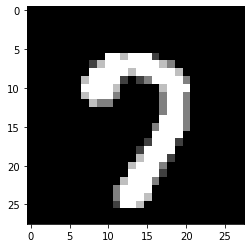

In [23]:
# Import MNIST : 
trainset_size = 60000
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])) # Train set
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])) # Test set

# split to train and test : 

X_train_full = mnist_trainset.data.numpy()
y_train_full = mnist_trainset.train_labels.numpy()
X_test  = mnist_testset.data.numpy()
y_test  = mnist_testset.test_labels.numpy()

temp, cols, rows = X_train_full.shape

X_train_full = X_train_full.reshape(-1,cols*rows)/255
X_test = X_test.reshape(-1,cols*rows)/255

# Show MNIST : 

mnistDataSetLen = mnist_trainset.data.shape[0]
i = torch.LongTensor(1).random_(0, mnistDataSetLen)
first_image = mnist_trainset.data[i]
first_image = np.array(first_image, dtype='float')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')

Define different learning algorithms that will be examined and compared to each other : 

In [0]:
class BaseModel(object):

    def __init__(self):
        pass

    def fit_predict(self):
        pass


class SvmModel(BaseModel):

    model_type = 'Support Vector Machine'
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training svm...')
        self.classifier = SVC(C=1, kernel='linear', probability=True,
                              class_weight=c_weight)
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted,
                self.test_y_predicted)


class LogModel(BaseModel):

    model_type = 'Multinominal Logistic Regression' 
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training multinomial logistic regression')
        train_samples = X_train.shape[0]
        self.classifier = LogisticRegression(
            C=50. / train_samples,
            multi_class='multinomial',
            penalty='l1',
            solver='saga',
            tol=0.1,
            class_weight=c_weight,
            )
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted,
                self.test_y_predicted)

class RfModel(BaseModel):

    model_type = 'Random Forest'
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training random forest...')
        self.classifier = RandomForestClassifier(n_estimators=500, class_weight=c_weight)
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted, self.test_y_predicted)

class NeuralNetworkModel(BaseModel):

    model_type = 'Neural Network'
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training Neural Network...')
        self.classifier =MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
                    solver='sgd', verbose=10, random_state=1,
                    learning_rate_init=.1)

        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted, self.test_y_predicted)

Define generic training procedure for different classification algorithms : 

In [0]:

class TrainModel:

    def __init__(self, model_object):        
        self.accuracies = []
        self.model_object = model_object()        

    def print_model_type(self):
        print (self.model_object.model_type)

    def train(self, X_train, y_train, X_val, X_test, c_weight):
        print ('Train set:', X_train.shape, 'y:', y_train.shape)
        print ('Val   set:', X_val.shape)
        print ('Test  set:', X_test.shape)
        t0 = time.time()
        (X_train, X_val, X_test, self.val_y_predicted,
         self.test_y_predicted) = \
            self.model_object.fit_predict(X_train, y_train, X_val, X_test, c_weight)
        self.run_time = time.time() - t0
        return (X_train, X_val, X_test)  
        
    def get_test_accuracy(self, i, y_test):
        classif_rate = np.mean(self.test_y_predicted.ravel() == y_test.ravel()) * 100
        self.accuracies.append(classif_rate)               
        print('--------------------------------')
        print('Iteration:',i)
        print('--------------------------------')
        print('y-test set:',y_test.shape)
        print('Example run in %.3f s' % self.run_time,'\n')
        print("Accuracy rate for %f " % (classif_rate))    
        print("Classification report for classifier %s:\n%s\n" % (self.model_object.classifier, metrics.classification_report(y_test, self.test_y_predicted)))
        print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, self.test_y_predicted))
        print('--------------------------------')


####**Query Selection** 

The most important tool in AL method is the sample selection function. This is the only point where we influence the learning process and it's crucial to use the right one.

Choosing the samples wisely is an important task since I wish to maximize the classification abilities and minimize the number of queries as possible.

Here are 3 common methods for sampling selection :

####**Random Selection Method :**

Select 'k' samples randomly.

####**Entropy Selection Method :**

In order to utilize all the possible label probabilities, use entropy measurment. The entropy formula is applied to each instance and the 'k' instances with the largest value is queried.

####**Margin Sampling Selection Method :**

The margin sampling strategy selects the 'k' instances that have the smallest difference between the first and second most probable labels. 




In [0]:

class BaseSelectionFunction(object):

    def __init__(self):
        pass

    def select(self):
        pass


class RandomSelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        random_state = check_random_state(0)
        selection = np.random.choice(probas_val.shape[0], initial_labeled_samples, replace=False)
        return selection


class EntropySelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        e = (-probas_val * np.log2(probas_val)).sum(axis=1)
        selection = (np.argsort(e)[::-1])[:initial_labeled_samples]
        return selection
      
      
class MarginSamplingSelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        rev = np.sort(probas_val, axis=1)[:, ::-1]
        values = rev[:, 0] - rev[:, 1]
        selection = np.argsort(values)[:initial_labeled_samples]
        return selection


####**Normalization**

Since new samples are being added to the training set all the time, normalization for all sets must be inversed and normalized again, because our sample distribution is changed in both the new validation and new training sets.

In [0]:

class Normalize(object):
    
    def normalize(self, X_train, X_val, X_test):
        self.scaler = MinMaxScaler()
        X_train = self.scaler.fit_transform(X_train)
        X_val   = self.scaler.transform(X_val)
        X_test  = self.scaler.transform(X_test)
        return (X_train, X_val, X_test) 
    
    def inverse(self, X_train, X_val, X_test):
        X_train = self.scaler.inverse_transform(X_train)
        X_val   = self.scaler.inverse_transform(X_val)
        X_test  = self.scaler.inverse_transform(X_test)
        return (X_train, X_val, X_test) 


Initially I would like to get a random sampling from the labeled data-pool.

In [0]:
def get_k_random_samples(initial_labeled_samples, X_train_full,
                         y_train_full):
    random_state = check_random_state(0)
    permutation = np.random.choice(trainset_size,
                                   initial_labeled_samples,
                                   replace=False)
    print ()
    print ('initial random chosen samples', permutation.shape),
#            permutation)
    X_train = X_train_full[permutation]
    y_train = y_train_full[permutation]
    X_train = X_train.reshape((X_train.shape[0], -1))
    bin_count = np.bincount(y_train.astype('int64'))
    unique = np.unique(y_train.astype('int64'))
    print (
        'initial train set:',
        X_train.shape,
        y_train.shape,
        'unique(labels):',
        bin_count,
        unique,
        )
    return (permutation, X_train, y_train)

####**Active Learning Algorithm:**


In [0]:
class ActiveLearningAlgorithm(object):

    accuracies = []

    def __init__(self, initial_labeled_samples, model_object, selection_function):
        self.initial_labeled_samples = initial_labeled_samples
        self.model_object = model_object
        self.sample_selection_function = selection_function

    def run(self, X_train_full, y_train_full, X_test, y_test):

        # Initialization - train with K samples the first classifier : 

        # Step 1 - Choose relevant samples:
        (permutation, X_train, y_train) = \
            get_k_random_samples(self.initial_labeled_samples,
                                 X_train_full, y_train_full)
        self.queried = self.initial_labeled_samples
        self.samplecount = [self.initial_labeled_samples]
        
        # Copy to new variable : 
        X_val = np.array([])
        y_val = np.array([])
        X_val = np.copy(X_train_full)
        X_val = np.delete(X_val, permutation, axis=0)
        y_val = np.copy(y_train_full)
        y_val = np.delete(y_val, permutation, axis=0)
        
        # normalize data
        normalizer = Normalize()
        X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)   
        
        #step 2 - Train :
        self.clf_model = TrainModel(self.model_object)
        (X_train, X_val, X_test) = self.clf_model.train(X_train, y_train, X_val, X_test, 'balanced')
        active_iteration = 1
        self.clf_model.get_test_accuracy(1, y_test)

        #Check stopping condition:
        while self.queried < max_queried:

            active_iteration += 1

            #Step 3 - Check Validation Probabilities:
            probas_val = \
                self.clf_model.model_object.classifier.predict_proba(X_val)
            print ('val predicted:',
                   self.clf_model.val_y_predicted.shape,
                   self.clf_model.val_y_predicted)
            print ('probabilities:', probas_val.shape, '\n',
                   np.argmax(probas_val, axis=1))

            uncertain_samples = \
                self.sample_selection_function.select(probas_val, self.initial_labeled_samples)

            # Step 4 - Normalization needs to be inversed and recalculated based on the new train and test set:
            X_train, X_val, X_test = normalizer.inverse(X_train, X_val, X_test)   

            # Step 5 - get the uncertain samples from the validation set:
            print ('trainset before', X_train.shape, y_train.shape)
            X_train = np.concatenate((X_train, X_val[uncertain_samples]))
            y_train = np.concatenate((y_train, y_val[uncertain_samples]))
            print ('trainset after', X_train.shape, y_train.shape)
            self.samplecount.append(X_train.shape[0])

            bin_count = np.bincount(y_train.astype('int64'))
            unique = np.unique(y_train.astype('int64'))
            print (
                'updated train set:',
                X_train.shape,
                y_train.shape,
                'unique(labels):',
                bin_count,
                unique,
                )

            X_val = np.delete(X_val, uncertain_samples, axis=0)
            y_val = np.delete(y_val, uncertain_samples, axis=0)
            print ('val set:', X_val.shape, y_val.shape)
            print ()

            # normalize again after creating the 'new' train/test sets
            normalizer = Normalize()
            X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)               
            
            #Step 6 - Train the model again with new training set
            self.queried += self.initial_labeled_samples
            (X_train, X_val, X_test) = self.clf_model.train(X_train, y_train, X_val, X_test, 'balanced')
            self.clf_model.get_test_accuracy(active_iteration, y_test)

        print ('final active learning accuracies',
               self.clf_model.accuracies)

####**Active Learning Preformance Analysis:**

In the analysis part I will put into test few subjects that can influence the active learning process: 

1. Number of queries in each iteration. 
2. Query selection method
3. Cassification algorithms


I ran the experiment by iterating over all of our training algorithms, all of selection functions and four option of k’s in the range of [200,150,100,50]. I I also limited my training session to a maximum of 600 queried samples.

Independently, I trained all models in fully supervised method (using a train-test split of 60K-10K) in order to set an upper-bound for the expected results from active learning process.



In [0]:
from sklearn.utils import check_random_state
from sklearn.preprocessing import MinMaxScaler
import time
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
import os
import json


print ('train:', X_train_full.shape, y_train_full.shape)
print ('test :', X_test.shape, y_test.shape)
classes = len(np.unique(y_test))
print ('unique classes', classes)
  
def experiment(d, models, selection_functions, Ks, repeats, contfrom):
    algos_temp = []
    print ('stopping at:', max_queried)
    count = 0
    for model_object in models:
      if model_object.__name__ not in d:
          d[model_object.__name__] = {}
      
      for selection_function in selection_functions:
        if selection_function.__name__ not in d[model_object.__name__]:
            d[model_object.__name__][selection_function.__name__] = {}
        
        for k in Ks:
            d[model_object.__name__][selection_function.__name__][str(k)] = []           
            
            for i in range(0, repeats):
                count+=1
                if count >= contfrom:
                    print ('Count = %s, using model = %s, selection_function = %s, k = %s, iteration = %s.' % (count, model_object.__name__, selection_function.__name__, k, i))
                    alg = ActiveLearningAlgorithm(k, 
                                       model_object, 
                                       selection_function
                                       )
                    alg.run(X_train_full, y_train_full, X_test, y_test)
                    d[model_object.__name__][selection_function.__name__][str(k)].append(alg.clf_model.accuracies)
                    if count % 5 == 0:
                        print(json.dumps(d, indent=2, sort_keys=True))
                    print ()
                    print ('---------------------------- FINISHED ---------------------------')
                    print ()
    return d


max_queried = 600 

repeats = 1

models = [RfModel, LogModel,SvmModel, NeuralNetworkModel]

selection_functions = [RandomSelection, MarginSamplingSelection, EntropySelection]

Ks = [200,150,100,50]

d = {}
stopped_at = -1 

d = experiment(d, models, selection_functions, Ks, repeats, stopped_at+1)
print (d)
results = json.loads(json.dumps(d, indent=2, sort_keys=True))
print(results)


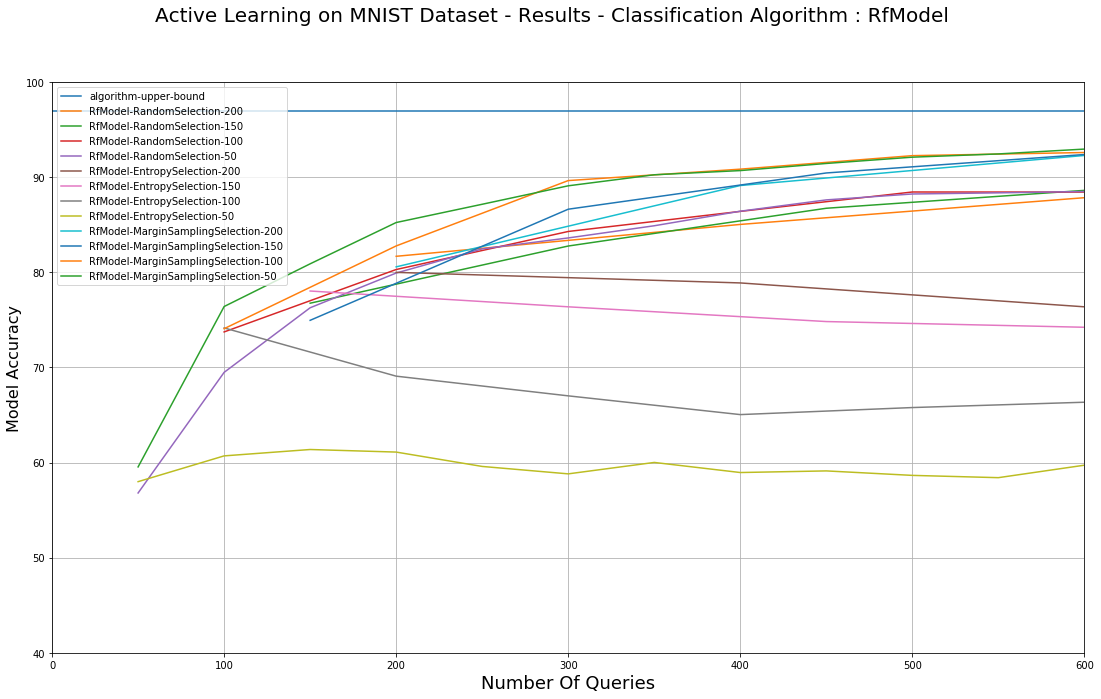

 
__________________________________________________________________________________________________________________________________________________________________ 
 


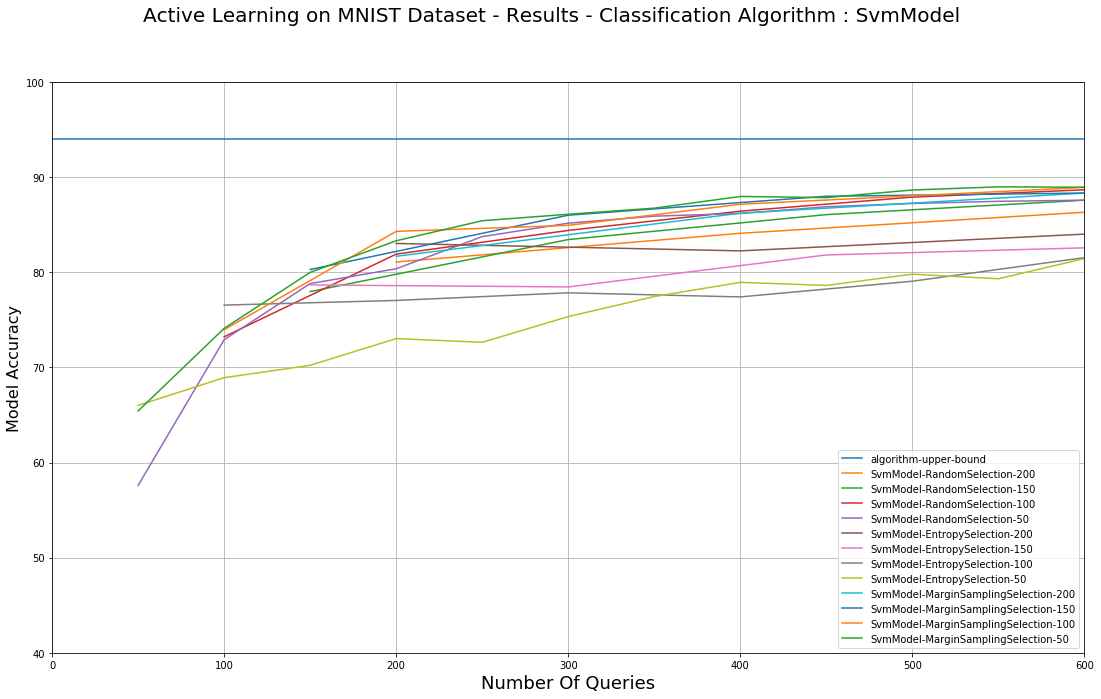

 
__________________________________________________________________________________________________________________________________________________________________ 
 


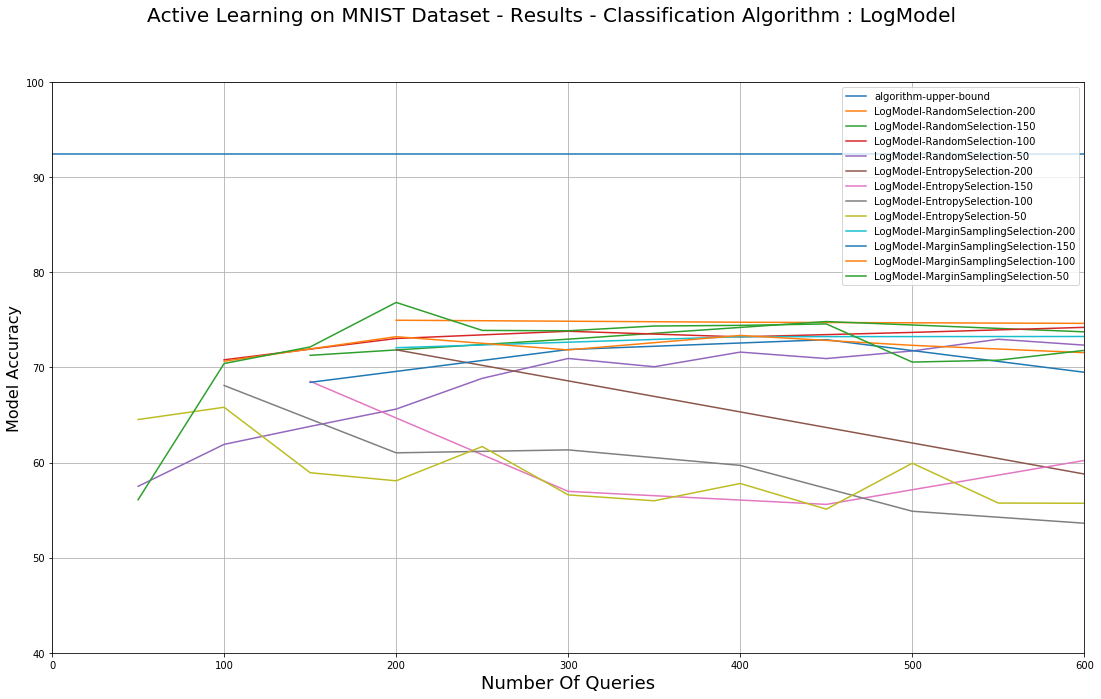

 
__________________________________________________________________________________________________________________________________________________________________ 
 


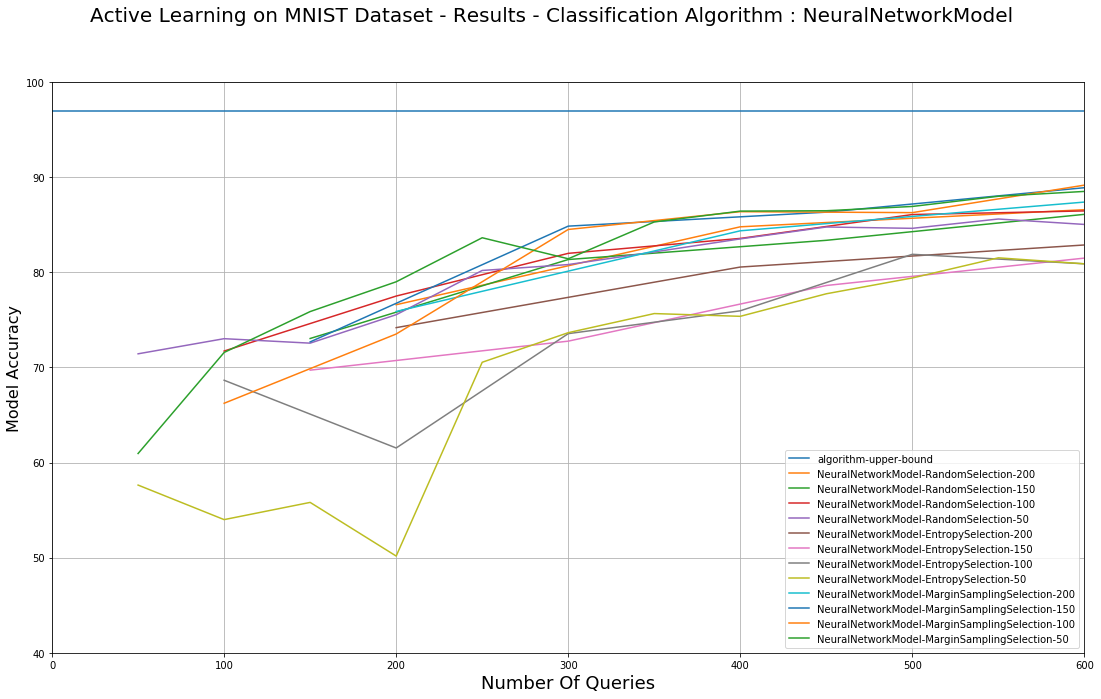

 
__________________________________________________________________________________________________________________________________________________________________ 
 


In [54]:

def performance_plot(fully_supervised_accuracy, dic, models, selection_functions, Ks, repeats):  
    fig, ax = plt.subplots()
    ax.plot([0,600],[fully_supervised_accuracy, fully_supervised_accuracy],label = 'algorithm-upper-bound')
    for model_object in models: 
      for selection_function in selection_functions:
        for idx, k in enumerate(Ks):
            x = np.arange(float(Ks[idx]), 600 + float(Ks[idx]), float(Ks[idx]))            
            Sum = np.array(dic[model_object][selection_function][k][0])
            for i in range(1, repeats):
                Sum = Sum + np.array(dic[model_object][selection_function][k][i])
            mean = Sum / repeats
            ax.plot(x, mean ,label = model_object + '-' + selection_function + '-' + str(k))
    ax.legend()
    ax.set_xlim([0,600])
    ax.set_ylim([40,100])
    ax.grid(True)
    fig.set_size_inches(18.5, 10.5)
    fig.suptitle("Active Learning on MNIST Dataset - Results - Classification Algorithm : " + model_object, fontsize=20)
    plt.xlabel('Number Of Queries', fontsize=18)
    plt.ylabel('Model Accuracy', fontsize=16)
    plt.show()
    print(" ")
    print("__________________________________________________________________________________________________________________________________________________________________ ")
    print(" ")

models_str = ['SvmModel', 'RfModel', 'LogModel','NeuralNetworkModel']
selection_functions_str = ['RandomSelection','EntropySelection', 'MarginSamplingSelection']
Ks_str = ['200','150','100','50']
repeats = 1

# Fully supervised classification results for all algorithms : 

random_forest_upper_bound = 97.
svm_upper_bound = 94.
log_upper_bound = 92.47
nn_upper_bound = 97.

total_experiments = len(models_str) * len(selection_functions_str) * len(Ks_str) * repeats

performance_plot(random_forest_upper_bound, d, ['RfModel'] , selection_functions_str    , Ks_str, 1)
performance_plot(svm_upper_bound, d, ['SvmModel'] , selection_functions_str    , Ks_str, 1)
performance_plot(log_upper_bound, d, ['LogModel'] , selection_functions_str    , Ks_str, 1)
performance_plot(nn_upper_bound, d, ['NeuralNetworkModel'] , selection_functions_str    , Ks_str, 1)

In [62]:
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

df = pd.DataFrame(d).T
df.fillna(0, inplace=True)
print(df)


                                                                                                                                                                                                                                                                                                                                         RandomSelection  \
RfModel             {'200': [[81.67999999999999, 85.03, 87.83999999999999]], '150': [[76.75, 82.76, 86.72999999999999, 88.61]], '100': [[73.72999999999999, 80.28999999999999, 84.28999999999999, 86.4, 88.44, 88.42999999999999]], '50': [[56.8, 69.48, 76.27000000000001, 79.92, 82.46, 83.61, 84.89, 86.42, 87.61, 88.23, 88.35, 88.49000000000001]]}   
LogModel            {'200': [[74.96000000000001, 74.75, 74.63]], '150': [[71.27, 72.97, 74.82, 73.74000000000001]], '100': [[70.8, 73.04, 73.8, 73.21, 73.68, 74.21]], '50': [[57.49999999999999, 61.91, 63.800000000000004, 65.62, 68.85, 70.94, 70.07, 71.61, 70.93, 71.73, 72.96000000000001, 72.34]]}       

####**Results Analysis:**

From the graphs and table I can see that : 

1. Random forest achieves highest classifications scores.

2. Margin sampling is the best query selection function.


> We can see the large influence that the selection function had on the preformances. For example - we can see that random forest model with k = 50 preformances is significantly higher when using margin sampling (92.95% accuracy) over entropy selection (59.72% accuracy). In both cases the model learns from the same number of samples from the training set, and yet, the difference is significant.


3. Best 'k' hyper-parameter is 50.



> We can see that in some cases, increasing the number of iterations (i.e decreasing the value of hyperparameter 'k') - helped the model to get better results. For example, neural network with margin sampling. 
With k = 100, after two iterations the accuracy is 73.50%; and when k=50, after four iterations accuracy is 79.0%. Meaning, 5.5% differnce for the same number of training samples. 



####**References:**

[From Theories to Queries: Active Learning in Practice by Burr Settles](http://proceedings.mlr.press/v16/settles11a/settles11a.pdf
)

[Active Learning: Curious AI Algorithms by Stefan Hosein](https://www.datacamp.com/community/tutorials/active-learning
)

[Active Learning Tutorial by Ori Cohen](https://towardsdatascience.com/active-learning-tutorial-57c3398e34d
)